## 1. 환경설정

In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

# from kerashypetune import KerasGridSearch

In [2]:
import os

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.family']='AppleGothic'

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path,files]),
                            index_col=index_col)
        df_raw = pd.concat((df_raw,df),axis=0)
    return df_raw

## 2. 데이터전처리

In [4]:
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브를 사용하는 경우

path = '/content/drive/MyDrive/dacon/water_level/data/'

_df_rf_raw = read_csv_by_dir('/'.join([path,'rf_data']),
                            index_col=0)

_df_water_raw = read_csv_by_dir('/'.join([path,'water_data']),
                               index_col=0)

_submission_raw = pd.read_csv('/'.join([path,'sample_submission.csv']),
                             index_col=0)

Mounted at /content/drive


In [5]:
# raw_data 보존하기
df_rf=_df_rf_raw.copy()
df_rf.name = "rain_data"

df_water=_df_water_raw.copy()
df_water.name = "water_data"

submission=_submission_raw.copy()
submission.name = "submission"

In [6]:
def index_to_datetime(df,format):
    df.index = pd.to_datetime(df.index,
                              format=format)
    return df

In [7]:
df_rf=index_to_datetime(df=df_rf,format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water,format='%Y-%m-%d %H:%M')
submission=index_to_datetime(df=submission,format='%Y-%m-%d %H:%M')

In [8]:
df_rf.sort_index(inplace=True)
df_water.sort_index(inplace=True)
submission.sort_index(inplace=True)

In [9]:
# 데이터 시간대 확인하기
def check_datetime(df):
    print(df.name)
    print(df.select_dtypes('datetime64[ns]').head(1).index[0])
    print(df.select_dtypes('datetime64[ns]').tail(1).index[0])
    return None

check_datetime(df_rf)
check_datetime(df_water)
check_datetime(submission)

rain_data
2012-05-01 00:00:00
2022-07-18 23:50:00
water_data
2012-05-01 00:00:00
2022-07-18 23:50:00
submission
2022-06-01 00:00:00
2022-07-18 23:50:00


In [10]:
data = pd.concat((df_rf,df_water),axis=1)

In [11]:
data.shape

(276336, 17)

In [12]:
# data와 target 하나 밀어주기 (과거데이터를 사용해야 함으로)
_data = data.reset_index(drop=True)

_data.index += 1
tot=_data.sort_index()
tot=tot.iloc[1:-1]

In [13]:
tot.isna().sum()

rf_10184100         0
rf_10184110         0
rf_10184140         0
swl               743
inf               743
sfw               743
ecpc              743
tototf            743
tide_level       4927
wl_1018662         59
fw_1018662      16380
wl_1018680         59
fw_1018680     196848
wl_1018683         59
fw_1018683       1279
wl_1019630         59
fw_1019630         59
dtype: int64

In [14]:
pred_col = submission.columns
pred_col

Index(['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'], dtype='object')

In [15]:
tot.fillna(tot.mean(),inplace=True)

In [16]:
train_data=tot.iloc[:-len(submission),:]
test_data=tot.iloc[-len(submission):,:]

In [17]:
test_data.isna().sum()

rf_10184100    0
rf_10184110    0
rf_10184140    0
swl            0
inf            0
sfw            0
ecpc           0
tototf         0
tide_level     0
wl_1018662     0
fw_1018662     0
wl_1018680     0
fw_1018680     0
wl_1018683     0
fw_1018683     0
wl_1019630     0
fw_1019630     0
dtype: int64

In [18]:
test_data.shape

(6912, 17)

In [19]:
submission.shape

(6912, 4)

## 3. 모델링

### 3-1. Time2Vec

In [20]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [21]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 24 # orig: 24 .  note, 24*7 = 168

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [50]:
### DEFINE MODEL STRUCTURES ###

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [51]:
### PREPARE DATA TO FEED MODELS ###

X1, Y1 = [], []
for sequence in gen_sequence(train_data.drop(pred_col.drop('wl_1018662'), axis=1), sequence_length, ['wl_1018662']):
    X1.append(sequence)
    
for sequence in gen_labels(train_data.drop(pred_col.drop('wl_1018662'), axis=1), sequence_length, ['wl_1018662']):
    Y1.append(sequence)
    
X1 = np.asarray(X1)
Y1 = np.asarray(Y1)

### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(train_data))
X_train1, X_test1 = X1[:train_dim], X1[train_dim:]
y_train1, y_test1 = Y1[:train_dim], Y1[train_dim:]

print(X_train1.shape, y_train1.shape)
print(X_test1.shape, y_test1.shape)

(188595, 24, 1) (188595, 1)
(80803, 24, 1) (80803, 1)


### 3-2. 하이퍼파리미터 설정

In [52]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

param_grid = {
    'unit': [64,32],
    't2v_dim': [128,64,16],
    'lr': [1e-2,1e-3], 
    'act': ['relu','relu'], 
    'epochs': 100, # 200,
    'batch_size': [128,512,1024]
}


base_param = {
    'unit': 64,
    't2v_dim': 64,
    'lr': 2e-3, 
    'act': 'relu', 
    'epochs': 100, # 200,
    'batch_size': 256
}

### 3-3 모델 구성

In [63]:
def model_run(model, x_train, y_train, checkpoint_path, optimizer="adam"):
  epochs = 500
  batch_size = 128

  callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001, mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1, mode='auto', restore_best_weights=True),
  ]
  model.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["accuracy"],
  )
  history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1, shuffle=False
  )

In [64]:
model_dir = "/content/drive/MyDrive/dacon/water_level/time2vec_model/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
### FIT T2V + LSTM ###
### this is muc hslower if using CPU and not GPU
# es = EarlyStopping(patience=3, verbose=0, min_delta=0.0005, monitor='val_loss', mode='auto', restore_best_weights=True)
## new : skip search, default model

# 체크포인트 파일 저장 경로
checkpoint_path1 = model_dir+"checkpoints_model_time2vec1.ckpt"

model1 = T2V_NN(param=base_param, dim=sequence_length)

model_run(model1, X_train1, y_train1, checkpoint_path1)
# model.fit(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)

# pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
pred_t2v = model1.predict(X_test1).ravel()
print("MAE")
mean_absolute_error(y_test1.ravel(), pred_t2v)

Epoch 1/500
1179/1179 [==============================] - ETA: 0s - loss: 1886.8206 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 186.85881, saving model to /content/drive/MyDrive/dacon/water_level/time2vec_model/checkpoints_model_time2vec1.ckpt
1179/1179 [==============================] - 58s 47ms/step - loss: 1886.8206 - accuracy: 0.0000e+00 - val_loss: 186.8588 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/500
1179/1179 [==============================] - ETA: 0s - loss: 233.4623 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 186.85881
1179/1179 [==============================] - 72s 61ms/step - loss: 233.4623 - accuracy: 0.0000e+00 - val_loss: 839.2638 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/500
1179/1179 [==============================] - ETA: 0s - loss: 498.8466 - accuracy: 0.0000e+00
Epoch 3: val_loss did not improve from 186.85881
1179/1179 [==============================] - 74s 63ms/step - loss: 498.8466 - accuracy: 0.0000e+00 - val_loss:

In [36]:
### PREPARE DATA TO FEED MODELS ###

X2, Y2 = [], []
for sequence in gen_sequence(train_data.drop(pred_col.drop('wl_1018680'), axis=1), sequence_length, ['wl_1018680']):
    X2.append(sequence)
    
for sequence in gen_labels(train_data.drop(pred_col.drop('wl_1018680'), axis=1), sequence_length, ['wl_1018680']):
    Y2.append(sequence)
    
X2 = np.asarray(X2)
Y2 = np.asarray(Y2)

### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(train_data))
X_train2, X_test2 = X2[:train_dim], X2[train_dim:]
y_train2, y_test2 = Y2[:train_dim], Y2[train_dim:]

print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

array([295.82318, 295.24393, 294.87955, ..., 290.53296, 286.84195,
       284.04816], dtype=float32)

In [ ]:
### FIT T2V + LSTM ###
### this is muc hslower if using CPU and not GPU
# es = EarlyStopping(patience=3, verbose=0, min_delta=0.0005, monitor='val_loss', mode='auto', restore_best_weights=True)
## new : skip search, default model

# 체크포인트 파일 저장 경로
checkpoint_path2 = model_dir+"checkpoints_model_time2vec2.ckpt"

model2 = T2V_NN(param=base_param, dim=sequence_length)

model_run(model2, X_train2, y_train2, checkpoint_path2)

# pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
pred_t2v2 = model2.predict(X_test2).ravel()
print("MAE")
mean_absolute_error(y_test2.ravel(), pred_t2v2)

In [ ]:
### PREPARE DATA TO FEED MODELS ###

X3, Y3 = [], []
for sequence in gen_sequence(train_data.drop(pred_col.drop('wl_1018683'), axis=1), sequence_length, ['wl_1018683']):
    X3.append(sequence)
    
for sequence in gen_labels(train_data.drop(pred_col.drop('wl_1018683'), axis=1), sequence_length, ['wl_1018683']):
    Y3.append(sequence)
    
X3 = np.asarray(X3)
Y3 = np.asarray(Y3)

### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(train_data))
X_train3, X_test3 = X3[:train_dim], X3[train_dim:]
y_train3, y_test3 = Y3[:train_dim], Y3[train_dim:]

print(X_train3.shape, y_train3.shape)
print(X_test3.shape, y_test3.shape)

In [ ]:
### FIT T2V + LSTM ###
### this is muc hslower if using CPU and not GPU
# es = EarlyStopping(patience=3, verbose=0, min_delta=0.0005, monitor='val_loss', mode='auto', restore_best_weights=True)
## new : skip search, default model

# 체크포인트 파일 저장 경로
checkpoint_path3 = model_dir+"checkpoints_model_time2vec3.ckpt"

model3 = T2V_NN(param=base_param, dim=sequence_length)

model_run(model3, X_train3, y_train3, checkpoint_path3)

# pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
pred_t2v3 = model3.predict(X_test3).ravel()
print("MAE")
mean_absolute_error(y_test3.ravel(), pred_t2v3)

In [ ]:
### PREPARE DATA TO FEED MODELS ###

X4, Y4 = [], []
for sequence in gen_sequence(train_data.drop(pred_col.drop('wl_1019630'), axis=1), sequence_length, ['wl_1019630']):
    X4.append(sequence)
    
for sequence in gen_labels(train_data.drop(pred_col.drop('wl_1019630'), axis=1), sequence_length, ['wl_1019630']):
    Y4.append(sequence)
    
X4 = np.asarray(X4)
Y4 = np.asarray(Y4)

### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(train_data))
X_train4, X_test4 = X4[:train_dim], X4[train_dim:]
y_train4, y_test4 = Y4[:train_dim], Y4[train_dim:]

print(X_train4.shape, y_train4.shape)
print(X_test4.shape, y_test4.shape)

In [ ]:
### FIT T2V + LSTM ###
### this is muc hslower if using CPU and not GPU
# es = EarlyStopping(patience=3, verbose=0, min_delta=0.0005, monitor='val_loss', mode='auto', restore_best_weights=True)
## new : skip search, default model

# 체크포인트 파일 저장 경로
checkpoint_path4 = model_dir+"checkpoints_model_time2vec4.ckpt"

model4 = T2V_NN(param=base_param, dim=sequence_length)

model_run(model4, X_train4, y_train4, checkpoint_path4)

# pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
pred_t2v4 = model4.predict(X_test4).ravel()
print("MAE")
mean_absolute_error(y_test4.ravel(), pred_t2v4)

## 4. 성능평가

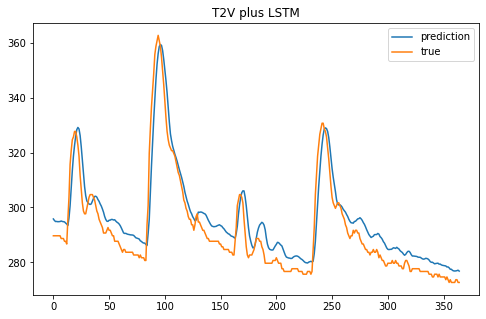

In [33]:
plt.figure(figsize=(8,5))

plt.plot(pred_t2v[:365], label='prediction')
plt.plot(y_test1.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

In [35]:
y_test1.ravel()

array([289.7, 289.7, 289.7, ..., 279.7, 278.7, 277.7])

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(pred_t2v2[:365], label='prediction')
plt.plot(y_test2.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(pred_t2v3[:365], label='prediction')
plt.plot(y_test3.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(pred_t2v4[:365], label='prediction')
plt.plot(y_test4.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

## 5. 제출 파일 생성

In [ ]:
prediction1 = model1.predict(X_test1).ravel()
prediction2 = model2.predict(X_test2).ravel()
prediction3 = model3.predict(X_test3).ravel()
prediction4 = model4.predict(X_test4).ravel()

In [ ]:
_submission_raw[pred_col[0]] = prediction1
_submission_raw[pred_col[1]] = prediction2
_submission_raw[pred_col[2]] = prediction3
_submission_raw[pred_col[3]] = prediction4

In [ ]:
_submission_raw.to_csv('/content/drive/MyDrive/dacon/water_level/submission_time2vec.csv')

In [ ]:
prediction1.shape

(6912, 18)

In [ ]:
_submission_raw.shape

(6912, 4)

In [ ]:
_submission_raw.isna().sum()

wl_1018662    0
wl_1018680    0
wl_1018683    0
wl_1019630    0
dtype: int64

In [ ]:
_submission_raw

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,278.700012,274.860012,273.58,270.299988
2022-06-01 00:10,278.700012,274.280012,273.76,269.299988
2022-06-01 00:20,280.700012,270.770012,272.05,267.299988
2022-06-01 00:30,283.700012,273.650012,273.12,264.299988
2022-06-01 00:40,284.700012,272.720012,271.17,261.299988
...,...,...,...,...
2022-07-18 23:10,287.700012,290.070012,287.47,303.299988
2022-07-18 23:20,287.700012,294.850012,298.79,306.299988
2022-07-18 23:30,286.700012,298.420012,300.54,308.299988


In [ ]:
# 리더보드 점수: 4.5210107544